In [138]:
import datetime as dt
import pandas as pd
import numpy as np
df = pd.read_csv('sample_year.csv')
df["date_time"] = pd.to_datetime(df["date_time"])

In [139]:
# Profit Loss
pl_sum = df["profit_loss"].sum()
print(f"トータル損益\t\t : {pl_sum:,.0f}円")
# Ratio of WIn - Lose
win_sum = df.loc[df["profit_loss"]>=0, "profit_loss"].sum()
lose_sum = df.loc[df["profit_loss"] < 0, "profit_loss"].sum()
print(f"収益合計\t\t\t：{win_sum:,.0f}円")
print(f"損益合計\t\t\t：{lose_sum:,.0f}円")
# Swap PL
swap_total = df.loc[df["trade_category"] == "swap", "profit_loss"].sum()
print(f"スワップ損益合計\t\t：{swap_total:,.0f}円")
# Trade times
entry_cnt = (df["trade_category"] == "entry").sum()
exit_cnt = (df["trade_category"] == "exit").sum()
print(f"エントリー回数\t\t：{entry_cnt:,} 回")
# Count of Win - Lose
win_cnt = df.loc[df["profit_loss"]>0, "profit_loss"].count()
lose_cnt = df.loc[df["profit_loss"] < 0, "profit_loss"].count()
print(f"収益トレード\t\t：{win_cnt:,.0f}回")
print(f"損失トレード\t\t：{lose_cnt:,.0f}回")
print(f"勝率\t\t\t：{win_cnt / (win_cnt + lose_cnt) * 100:,.2f}％")
# Win pips
win_lot = df.loc[df["profit_loss"] > 0, "executed_amount"].sum()
win_pip = win_sum / win_lot
# Lose pips
lose_lot = df.loc[df["profit_loss"] < 0, "executed_amount"].sum()
lose_pip = lose_sum / lose_lot
print(f"収益トレード平均獲得PIPS\t：{win_pip:,.3f}")
print(f"損失トレード平均獲得PIPS\t：{lose_pip:,.3f}")
print(f"Risk Reward Ratio\t：{win_pip/-lose_pip:.2f}")
# Avg lot Win - Lose
win_lot_per_trade = win_lot / win_cnt
lose_lot_per_trade = lose_lot / lose_cnt
print(f"収益トレード平均建玉\t：{win_lot_per_trade:,.0f}通貨")
print(f"損失トレード平均建玉\t：{lose_lot_per_trade:,.0f}通貨")
# Entry bid ask
bid_entry= ((df["trade_category"] == "entry") & (df["bid_ask"] == "sell")).sum()
ask_entry= ((df["trade_category"] == "entry") & (df["bid_ask"] == "buy")).sum()
print(f"BID ASK エントリー回数\t：Bid => {bid_entry}, Ask => {ask_entry}")

トータル損益		 : -820,890円
収益合計			：18,133,988円
損益合計			：-18,954,878円
スワップ損益合計		：-142,514円
エントリー回数		：11,003 回
収益トレード		：8,455回
損失トレード		：2,582回
勝率			：76.61％
収益トレード平均獲得PIPS	：0.027
損失トレード平均獲得PIPS	：-0.102
Risk Reward Ratio	：0.27
収益トレード平均建玉	：79,429通貨
損失トレード平均建玉	：72,119通貨
BID ASK エントリー回数	：Bid => 5298, Ask => 5705


In [140]:
# Remove trade_category of "swap" and "FXネオ手数料"
df = df[(df["trade_category"]=="entry") | (df["trade_category"]=="exit")]

In [142]:
entry_df = df[df["trade_category"]=="entry"]
exit_df = df[df["trade_category"]=="exit"]

In [ ]:
traded_currency_pair_list = entry_df["currency_pair"].drop_duplicates().to_list()

trade_set_list = []

def match_ab_pairs(pair):
    """
    pair = [
      [{keyA1: valA1}, {keyA2: valA2}, ...],   # Aの配列
      [{keyB1: valB1}, {keyB2: valB2}, ...]   # Bの配列
    ]

    要件:
      1) Aの各要素(単一の値)は、Bの一つまたは複数の値の合計に等しい
      2) A, Bの全要素を使い切る
      3) 同じ合計条件なら、キーの値が近い(絶対値差)ものを優先
      4) 結果は [[A_key, [B_key(s)]]] という形式で返す
         例: [[1169, [1173]], [3084, [3088, 3089]]] など
    """

    # A_list, B_list を (key, value) のリストに変換
    a_list = [(list(d.keys())[0], list(d.values())[0]) for d in pair[0]]
    b_list = [(list(d.keys())[0], list(d.values())[0]) for d in pair[1]]

    # A, B の合計値が一致しない場合、解は存在しない
    sum_a = sum(val for _, val in a_list)
    sum_b = sum(val for _, val in b_list)
    if abs(sum_a - sum_b) > 1e-9:
        # 合計が違う → 解なし
        return None

    # キー昇順ソート: キーが近い順を優先したい時に役立つ
    a_sorted = sorted(a_list, key=lambda x: x[0])  # (keyA, valA)
    b_sorted = sorted(b_list, key=lambda x: x[0])  # (keyB, valB)

    #-----------------------------------------------
    # すべてのBの要素を partition して、各パーティションが A_val に一致するようにしたい
    # (Subset Sum の連続)
    # ここではバックトラックで全探索 (要素数が多い場合は爆発的に遅くなる)
    #-----------------------------------------------

    used = [False]*len(b_sorted)  # Bの要素を使用済みかどうか
    best_result = []
    best_score = float('inf')  # score = キー差の合計が小さいほど良い

    def backtrack(i, current_pairs, current_score):
        nonlocal best_result, best_score

        # ベースケース: Aのすべての要素を処理
        if i == len(a_sorted):
            # Bが全て使われているか確認
            if all(used):
                if current_score < best_score:
                    best_result = current_pairs[:]
                    best_score = current_score
            return

        a_key, a_val = a_sorted[i]

        # Bの部分集合を探す → 合計が a_val
        candidates = []

        def subset_sum_b(start, remaining, chosen, chosen_indices, chosen_key_diff):
            if abs(remaining) < 1e-9:
                # 完成
                # (B_keys, sum_of_key_diff, indices_list)
                candidates.append((chosen[:], chosen_key_diff, chosen_indices[:]))
                return
            if start >= len(b_sorted):
                return

            for idx in range(start, len(b_sorted)):
                if not used[idx]:
                    b_key, b_val = b_sorted[idx]
                    if b_val <= remaining + 1e-9:
                        new_diff = chosen_key_diff + abs(a_key - b_key)
                        chosen.append(b_key)
                        chosen_indices.append(idx)
                        subset_sum_b(idx+1, remaining - b_val, chosen, chosen_indices, new_diff)
                        chosen.pop()
                        chosen_indices.pop()

        subset_sum_b(0, a_val, [], [], 0)

        if not candidates:
            return  # 合計が a_val になる組合せがない→失敗

        # キー差が小さい順にソート
        candidates.sort(key=lambda x: x[1])

        # 候補を試す
        for bkeys, diff, indices in candidates:
            # indices の要素を used=True にして再帰
            for idx_b in indices:
                used[idx_b] = True

            backtrack(i+1, current_pairs+[[a_key, bkeys]], current_score+diff)

            # 巻き戻し
            for idx_b in indices:
                used[idx_b] = False

    backtrack(0, [], 0)
    return best_result

def gen_trade_set(entry_df,exit_df):
    price_list = entry_df["executed_price"].drop_duplicates().to_list()
    # Making pair group
    pair_group_list = []
    for i in price_list:
        column_name = "executed_amount"
        condition_for_entry = entry_df["executed_price"] == i
        res_entry =  [{idx: val} for idx, val in entry_df.loc[condition_for_entry, column_name].items()]
        condition_for_exit = exit_df["entry_price"] == i
        res_exit =  [{idx: val} for idx, val in exit_df.loc[condition_for_exit, column_name].items()]
        pair_group_list.append([res_entry,res_exit])
    
    # Gen trade set
    for l in pair_group_list:
        entry_list = l[0]
        exit_list = l[1]
        entry_index_list = [list(d.keys())[0] for d in entry_list]
        exit_index_list = [list(d.keys())[0] for d in exit_list]
        if len(entry_list) == 1:
            entry_index = list(entry_list[0].keys())[0]
            if len(exit_list) == 1:
                trade_set_list.append([entry_index,list(exit_list[0].keys())])
            else:
                trade_set_list.append([entry_index,exit_index_list])
        elif (len(entry_index_list) == 2) and (len(exit_index_list) == 2):
            smaller_index = sorted(entry_index_list)[0]
            res_exit = exit_index_list[0] if abs(smaller_index - exit_index_list[0]) < abs(smaller_index - exit_index_list[1]) else exit_index_list[1]
            trade_set_list.append([smaller_index,[res_exit]])
            trade_set_list.append([sorted(entry_index_list)[1],[next(x for x in exit_index_list if x != res_exit)]])
        else:
            res_matching = match_ab_pairs(l)
            print(res_matching)
            print(trade_set_list)
    

test_traded_currency_pair_list=["USDJPY"]
for pair in test_traded_currency_pair_list:
# for pair in test_traded_currency_pair_list:
    # entryDF
    tmp_entry_df = entry_df[entry_df["currency_pair"] == pair]
    # entryDFをbuy, sell に分割
    tmp_entry_buy_df = tmp_entry_df[tmp_entry_df["bid_ask"] == "buy"]
    tmp_entry_sell_df = tmp_entry_df[tmp_entry_df["bid_ask"] == "sell"]
    # exit DF
    tmp_exit_df = exit_df[exit_df["currency_pair"] == pair]
    # exitDFをbuy, sell に分割
    tmp_exit_buy_df = tmp_exit_df[tmp_exit_df["bid_ask"] == "buy"]
    tmp_exit_sell_df = tmp_exit_df[tmp_exit_df["bid_ask"] == "sell"]

    gen_trade_set(tmp_entry_buy_df,tmp_exit_sell_df)





IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



[[15417, [15419]], [15422, [15433]], [15423, [15434]], [15424, [15435]], [15425, [15436]], [15426, [15437]], [15427, [15438]], [15428, [15439]], [21353, [21354]]]
[[14, [15]], [20, [21]], [18, [19]], [18649, [18655]], [22, [23]], [24, [25]], [26, [27]], [74, [75]], [32, [33]], [36, [37]], [38, [39]], [46, [47]], [9741, [9743]], [50, [51]], [52, [53]], [54, [55]], [56, [57]], [76, [77]], [60, [61]], [64, [65]], [78, [79]], [82, [83]], [88, [89]], [90, [91]], [92, [93]], [100, [101]], [18755, [18758]], [104, [105]], [106, [107]], [20101, [20104]], [110, [111]], [18643, [18644]], [116, [117]], [18921, [18922]], [120, [121]], [124, [125]], [9978, [9992]], [126, [127]], [18641, [18642]], [130, [131]], [132, [133]], [134, [135]], [138, [139]], [140, [141]], [144, [145]], [148, [149]], [150, [151]], [152, [153]], [154, [155]], [156, [157]], [158, [159]], [160, [161]], [162, [163]], [166, [167]], [168, [169]], [180, [181]], [170, [171]], [172, [173]], [174, [175]], [176, [177]], [182, [183]], 

In [ ]:
from itertools import permutations, combinations

traded_currency_pair_list = entry_df["currency_pair"].drop_duplicates().to_list()

trade_set_list = []

def match_keys(pair_of_lists):
    """
    pair_of_lists: [ list1, list2 ] の形で、
      list1: [{key: value}, {key: value}, ...]
      list2: [{key: value}, {key: value}, ...]
    
    条件:
    - list1 と list2 の要素数が同じと想定
    - list1 の sum(values) と list2 の sum(values) が等しいと想定
    - 同じ値の場合は key が近いもの同士を優先 (例としてキーを昇順にソートして対応づけ)
    
    戻り値:
      [[list1_key, list2_key], [list1_key, list2_key], ...] という形のリスト
    """
    list1, list2 = pair_of_lists  # 2つのリストを取り出す
    
    # list1 → [(key, value), (key, value), ...] に変換
    lv1 = [(list(d.keys())[0], list(d.values())[0]) for d in list1]
    # list2 → [(key, value), (key, value), ...] に変換
    lv2 = [(list(d.keys())[0], list(d.values())[0]) for d in list2]
    
    # キー昇順にソート
    lv1_sorted = sorted(lv1, key=lambda x: x[0])  # キーでソート
    lv2_sorted = sorted(lv2, key=lambda x: x[0])  # キーでソート
    
    # 対応付け: [[key1, key2], ...]
    # 1対1でペアを作る (順番通りに zip する)
    result = []
    for (k1, v1), (k2, v2) in zip(lv1_sorted, lv2_sorted):
        result.append([k1, k2])
    
    return result

def gen_trade_set(entry_df,exit_df):
    price_list = entry_df["executed_price"].drop_duplicates().to_list()
    # Making pair group
    pair_group_list = []
    for i in price_list:
        column_name = "executed_amount"
        condition_for_entry = entry_df["executed_price"] == i
        res_entry =  [{idx: val} for idx, val in entry_df.loc[condition_for_entry, column_name].items()]
        condition_for_exit = exit_df["entry_price"] == i
        res_exit =  [{idx: val} for idx, val in exit_df.loc[condition_for_exit, column_name].items()]
        pair_group_list.append([res_entry,res_exit])
    
    # Gen trade set
    for l in pair_group_list:
        entry_list = l[0]
        exit_list = l[1]
        entry_index_list = [list(d.keys())[0] for d in entry_list]
        exit_index_list = [list(d.keys())[0] for d in exit_list]
        if len(entry_list) == 1:
            entry_index = list(entry_list[0].keys())[0]
            if len(exit_list) == 1:
                trade_set_list.append([entry_index,list(exit_list[0].keys())])
            else:
                trade_set_list.append([entry_index,exit_index_list])
        elif (len(entry_index_list) == 2) and (len(exit_index_list) == 2):
            smaller_index = sorted(entry_index_list)[0]
            res_exit = exit_index_list[0] if abs(smaller_index - exit_index_list[0]) < abs(smaller_index - exit_index_list[1]) else exit_index_list[1]
            trade_set_list.append([smaller_index,[res_exit]])
            trade_set_list.append([sorted(entry_index_list)[1],[next(x for x in exit_index_list if x != res_exit)]])
        else:
            get_pair = match_keys(l)
            print(get_pair)



test_traded_currency_pair_list=["USDJPY"]
for pair in test_traded_currency_pair_list:
# for pair in test_traded_currency_pair_list:
    # entryDF
    tmp_entry_df = entry_df[entry_df["currency_pair"] == pair]
    # entryDFをbuy, sell に分割
    tmp_entry_buy_df = tmp_entry_df[tmp_entry_df["bid_ask"] == "buy"]
    tmp_entry_sell_df = tmp_entry_df[tmp_entry_df["bid_ask"] == "sell"]
    # exit DF
    tmp_exit_df = exit_df[exit_df["currency_pair"] == pair]
    # exitDFをbuy, sell に分割
    tmp_exit_buy_df = tmp_exit_df[tmp_exit_df["bid_ask"] == "buy"]
    tmp_exit_sell_df = tmp_exit_df[tmp_exit_df["bid_ask"] == "sell"]

    gen_trade_set(tmp_entry_buy_df,tmp_exit_sell_df)

    



[[30, 31], [34, 35], [68, 69], [20352, 20353]]
[[42, 43], [9997, 10000], [9998, 10001], [18741, 18743]]
[[72, 73], [19721, 19724], [19723, 19726], [20355, 20357]]
[[86, 87], [18534, 18536], [18650, 18656]]
[[96, 97], [9945, 9948], [20354, 20356]]
[[186, 187], [190, 191], [196, 197], [18987, 18988]]
[[268, 269], [9993, 9994], [18658, 18659], [18783, 18785]]
[[404, 405], [455, 458], [456, 459], [457, 460]]
[[513, 532], [21859, 21861], [21860, 21862]]
[[602, 604], [701, 703], [887, 888]]
[[610, 615], [1137, 1138], [3181, 3185]]
[[634, 638], [1168, 1172], [3046, 3061]]
[[689, 690], [878, 879], [1084, 1092]]
[[700, 702], [1037, 1039], [1102, 1104]]
[[733, 736], [836, 837], [3062, 3068]]
[[829, 831], [895, 896], [3156, 3160], [3158, 3162], [6447, 6448]]
[[899, 900], [2575, 2578], [3129, 3131], [3149, 3154]]
[[1163, 1165], [2603, 2604], [3094, 2605]]
[[1169, 1173], [3084, 3088], [3085, 3089]]
[[1228, 1230], [1229, 1231], [1962, 1965]]
[[1543, 1547], [1544, 1548], [7453, 7455]]
[[1613, 1616], 

In [144]:
columns = [
    "trade_set_list"
    ,"entry_date_time"
    ,"avg_exit_time"
    ,"currency_pair"
    ,"entry_bid_ask"
    ,"entry_amount"
    ,"entry_price"
    ,"avg_exit_price"
    ,"profit_loss"
    ,"hold_time_sec"
    ,"pips"
]

dtypes = {
    "trade_set_list" : object 
    ,"entry_date_time" : "datetime64[ns]"
    ,"avg_exit_time" : "datetime64[ns]"
    ,"currency_pair" : str
    ,"entry_bid_ask" : str
    ,"entry_amount" : float
    ,"entry_price" : float
    ,"avg_exit_price" : float
    ,"profit_loss" : float
    ,"hold_time_sec" : float
    ,"pips" : float
}
# 空のデータフレームを作成
trade_df = pd.DataFrame(columns=columns).astype(dtypes)

In [145]:
df.dtypes

date_time          datetime64[ns]
trade_category             object
trade_id                    int64
currency_pair              object
bid_ask                    object
executed_amount           float64
executed_price            float64
entry_price               float64
profit_loss               float64
dtype: object

In [158]:
data_list = []
for l in trade_set_list:
    tmp_list = []
    
    # trade_set_list
    nested_tuple = tuple(tuple(x) if isinstance(x, list) else x for x in l)
    tmp_list.append(nested_tuple)
    
    # entry_date_time
    entry_time = df.loc[l[0],"date_time"]
    tmp_list.append(entry_time)
    
    # avg_exit_time ( calc )
    # 平均を取りたい date_time の行を選択（例えば index 0, 1, 2, 3）
    selected_dates = df.loc[l[1], "date_time"]
    # 選択した date_time の平均
    mean_date_time = selected_dates.mean()
    exit_time = mean_date_time
    tmp_list.append(exit_time)
    
    # currency_pair
    tmp_list.append(df.loc[l[0],"currency_pair"])
    
    # entry_bid_ask
    tmp_list.append(df.loc[l[0],"bid_ask"])
    
    # entry_amount
    entry_amount = df.loc[l[0],"executed_amount"]
    tmp_list.append(entry_amount)
    
    # entry_price
    entry_price = df.loc[l[0],"executed_price"]
    tmp_list.append(entry_price)
    
    # avg_exit_price ( calc )
    gokei = 0.0
    for i in l[1]:
        gokei += df.loc[i,"executed_price"]
    avg_exit_price = gokei/len(l[1])
    tmp_list.append(avg_exit_price)

    # sum_profit_loss
    sum_profit_loss = 0.0
    for i in l[1]:
        sum_profit_loss += df.loc[i,"profit_loss"]
    tmp_list.append(sum_profit_loss)

    # hold_time_sec
    # 差分を秒単位で取得し、小数点以下2桁で丸める
    diff_seconds = round((exit_time - entry_time).total_seconds(), 2)
    tmp_list.append(diff_seconds)
    
    # pips
    pips = sum_profit_loss / entry_amount
    tmp_list.append(pips)
        
    data_list.append(tmp_list)

In [147]:
# trade_dfにdata_listを代入
for i, row in enumerate(data_list):
    trade_df.loc[i] = pd.Series(row, index=trade_df.columns)
# すべての行を入れ終わったら改めて型を指定
trade_df = trade_df.astype(dtypes)

- 獲得PIPS
- 獲得PIPS数ヒストグラム

In [148]:
import matplotlib.pyplot as plt

In [149]:
print(trade_df["pips"].sum())
print(trade_df["pips"].mean())
print(trade_df["pips"].max())
print(trade_df["pips"].min())


7.648916915841299
0.00167152904629399
1.113
-6.208


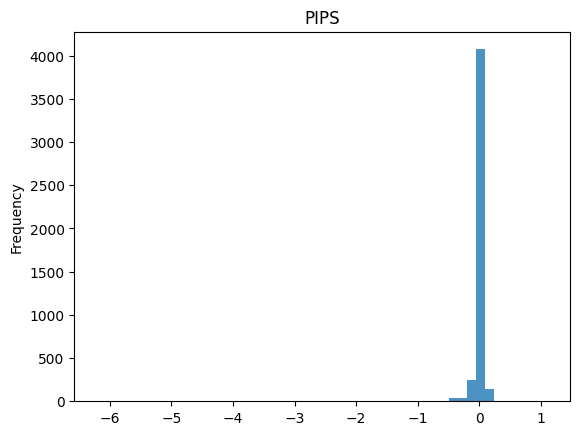

In [150]:
trade_df["pips"].plot.hist(title='PIPS', bins=50, alpha=0.8)
plt.show()

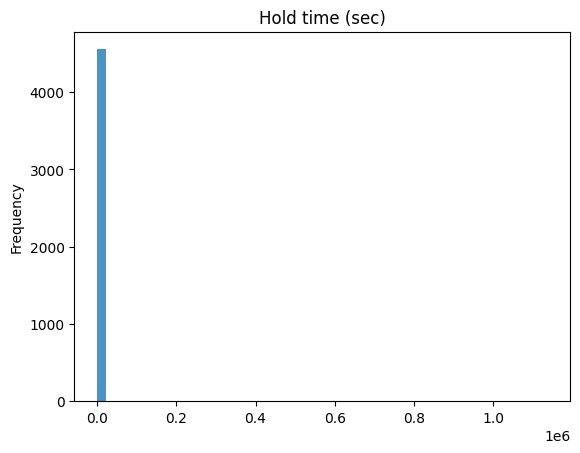

In [151]:
trade_df["hold_time_sec"].plot.hist(title='Hold time (sec)', bins=50, alpha=0.8)
plt.show()

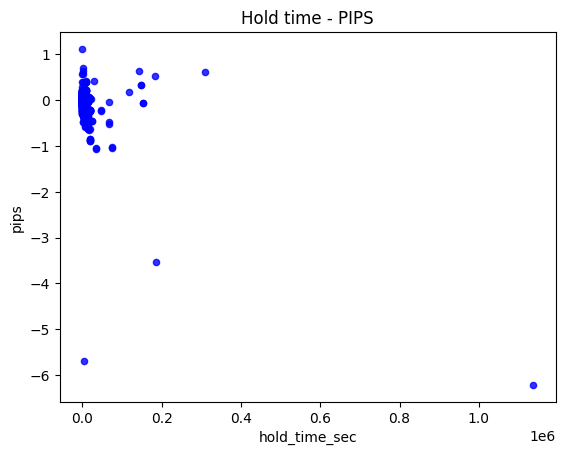

In [152]:
# 散布図を作成
trade_df[["hold_time_sec","pips"]].plot.scatter(title = "Hold time - PIPS", x="hold_time_sec", y="pips", alpha=0.8, color="blue")

# 表示
plt.show()


In [156]:
trade_df[trade_df["pips"]< -3]

,trade_set_list,entry_date_time,avg_exit_time,currency_pair,entry_bid_ask,entry_amount,entry_price,avg_exit_price,profit_loss,hold_time_sec,pips
175,"(510, (531,))",2024-07-18 13:14:19,2024-07-31 17:08:39,USDJPY,buy,3000.0,156.453,150.245,-18624.0,1137260.0,-6.208
176,"(533, (535,))",2024-07-31 17:59:03,2024-08-02 21:40:10,USDJPY,buy,2000.0,150.924,147.395,-7058.0,186067.0,-3.529
2000,"(7975, (7977,))",2024-10-07 10:23:44,2024-10-07 11:19:44,USDJPY,buy,10000.0,148.523,148.223,-57000.0,3360.0,-5.700


In [154]:
import sys

# Making set
entry_list = []
exit_list = []
trade_set_list = []

# データのindexをentryとexitのリストに格納
for index, row in df.iterrows():
    if row["trade_category"] == "entry":
        entry_list.append(index)
    elif row["trade_category"] == "euuxit":
        exit_list.append(index)

# データ数の確認
if (len(entry_list) + len(exit_list)) != len(df):
    print("trade_categoryカラムにentry,exit以外のデータが含まれているようです")
    sys.exit()

used_exit_list = set()
for i in entry_list:
    tmp_list = []
    tmp_sum = 0
    list_on_hold = []
    
    for j in exit_list:
        if j in used_exit_list:
            continue

        # Entry と Exit のペアを正しくマッチング
        if (df.loc[i, "currency_pair"] == df.loc[j, "currency_pair"]) and \
           (df.loc[i, "bid_ask"] != df.loc[j, "bid_ask"]) and \
           (df.loc[i, "executed_price"] == df.loc[j, "entry_price"]):
            # 数量も同じならOKで次へ
            if df.loc[i,"executed_amount"] == df.loc[j, "executed_amount"]:
                tmp_list.append(j)
                used_exit_list.add(j)
                break
            elif df.loc[i,"executed_amount"] < df.loc[j, "executed_amount"]:
                continue
            elif (df.loc[i,"executed_amount"] > df.loc[j, "executed_amount"]) and (df.loc[i,"executed_amount"] == (df.loc[j,"executed_amount"] + tmp_sum)):
                list_on_hold.append(j)
                tmp_list = list_on_hold
                used_exit_list.update(list_on_hold)
                break
            else:
                tmp_sum += df.loc[j, "executed_amount"]
                list_on_hold.append(j) 
                continue
        else:
            continue
        
    trade_set_list.append([i, tmp_list])

trade_categoryカラムにentry,exit以外のデータが含まれているようです


SystemExit: 

/Users/hirotatomohisa/Library/Python/3.9/lib/python/site-packages/IPython/core/interactiveshell.py:3558: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
